In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from skgstat import Variogram
np.random.seed(8004)

In [2]:
## Functions used
def Matern_cov(sigma, eta, t):
    '''
    :param sigma: scaling coef
    :param eta: range coef
    :param t: distance matrix
    :return: matern covariance
    '''
    return sigma ** 2 * (1 + eta * t) * np.exp(-eta * t)

# def
def plotf(Y, string):
    plt.figure(figsize=(5,5))
    plt.imshow(Y)
    plt.title(string)
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.gca().invert_yaxis()
    plt.show()

def design_matrix(sites1v, sites2v):
    '''
    :param sites1v:
    :param sites2v:
    :return:
    '''
    return np.hstack((np.ones([len(sites1v), 1]), sites1v, sites2v))

def mu(H, alpha):
    '''
    :param sites1v: grid along east direction
    :param sites2v: grid along north direction
    :param beta: regression coef
    :return: prior mean
    '''
    beta = np.hstack((-alpha, alpha, alpha))
    return np.dot(H, beta)

def sampling_design(n, M):
    '''
    :param n:
    :param M:
    :return:
    '''
    F = np.zeros([M, n])
    ind = np.random.randint(n, size = M)
    for i in range(M):
        F[i, ind[i]] = True
    return F, ind

In [3]:
##########STEP 1: Set up grid ####################################################################
# Setup the grid
n1 = 25 # number of grid points along east direction
n2 = 25 # number of grid points along north direction
n = n1 * n2 # total number of grid points

sites1 = np.arange(n1).reshape(-1, 1)
sites2 = np.arange(n2).reshape(-1, 1)
ww1 = np.ones([n1, 1])
ww2 = np.ones([n2, 1])
sites1 = sites1 * ww1.T
sites2 = ww2 * sites2.T

sites1v = sites1.flatten().reshape(-1, 1)
sites2v = sites2.flatten().reshape(-1, 1)

# Compute the distance matrix
ddE = np.abs(sites1v * np.ones([1, n]) - np.ones([n, 1]) * sites1v.T)
dd2E = ddE * ddE
ddN = np.abs(sites2v * np.ones([1, n]) - np.ones([n, 1]) * sites2v.T)
dd2N = ddN * ddN
t = np.sqrt(dd2E + dd2N)

# plotf(t, "distance matrix")


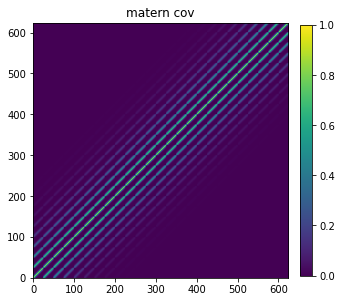

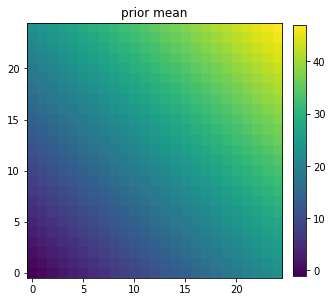

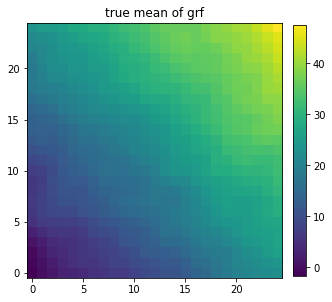

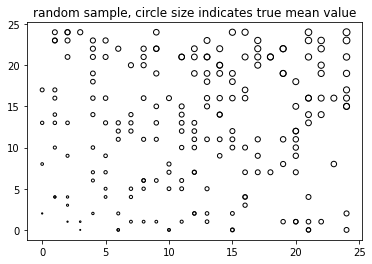

In [4]:
# Simulate the initial random field
alpha = 1.0 # beta as in regression model
sigma = 1.0 # scaling coef in matern kernel
eta = .8 # range coef in matern kernel
# eta = 10 # range coef in matern kernel
tau = .05 # iid noise

BETA_TRUE = np.array([[-alpha], [alpha], [alpha]])
THETA_TRUE = np.array([[sigma], [eta], [tau]])

Sigma = Matern_cov(sigma, eta, t)  # matern covariance
# C_theta = Sigma + tau ** 2 * np.identity(n)
plotf(Sigma, "matern cov")
# plotf(C_theta, "C theta covariance")

L = np.linalg.cholesky(Sigma)  # lower triangle matrix
# L = np.linalg.cholesky(C_theta)  # lower triangle matrix

x = np.dot(L, np.random.randn(n).reshape(-1, 1))
H = design_matrix(sites1v, sites2v)
mu_prior = mu(H, alpha).reshape(n, 1)
plotf(np.copy(mu_prior).reshape(n1, n2), "prior mean")
mu_real = mu_prior + x  # add covariance
plotf(np.copy(mu_real).reshape(n1, n2), "true mean of grf")

# sampling from realisations
M = 200
F, ind = sampling_design(n, M)
G = np.dot(F, H)
y_sampled = np.dot(F, mu_real) + tau * np.random.randn(M).reshape(-1, 1)
x_ind, y_ind = np.unravel_index(ind, (n1, n2))
x_ind = x_ind.reshape(-1, 1)
y_ind = y_ind.reshape(-1, 1)

plt.figure()
plt.scatter(x_ind, y_ind, y_sampled, facecolors='none', edgecolors='k')
plt.title("random sample, circle size indicates true mean value")
plt.show()


In [5]:
############ STEP 2: ESTIMATE PARAMETERS ###############################################################
def C_matrix(theta):
    '''
    :param theta:
    :return:
    '''
    sigma, eta, tau = theta
    Sigma = Matern_cov(sigma, eta, t)
    C = np.dot(F, np.dot(Sigma, F.T)) + np.identity(F.shape[0]) * tau ** 2
    return C


def dC_dsimga(theta):
    '''
    :param theta:
    :return:
    '''
    sigma, eta, tau = theta
    Km = Matern_cov(1.0, eta, t) # t here is the distance matrix, H is the design matrix, similar to X
    dC_dsgm = np.dot(F, np.dot(Km, F.T))
    return dC_dsgm


def dC_deta(theta):
    '''
    :param theta:
    :return:
    '''
    sigma, eta, tau = theta
    Kn = sigma ** 2 * (-eta * t) * np.exp(-eta * t)
    return np.dot(F, np.dot(Kn, F.T))


def dC_dtau(theta):
    '''
    :param theta:
    :return:
    '''
    return np.identity(F.shape[0])

epsilon is  0.031174072980949066
epsilon is  0.03889463461055424
epsilon is  0.031483280326483815
epsilon is  0.032095144414084176
epsilon is  0.02807966357314288
epsilon is  0.026587193640213617
epsilon is  0.023945289186411887
epsilon is  0.022091690349240474
epsilon is  0.02011689659363084
epsilon is  0.018396182651065327
epsilon is  0.016821616271088077
epsilon is  0.015339840722755481
epsilon is  0.01404823055599434
epsilon is  0.012802022056062035
epsilon is  0.011730005114528496
epsilon is  0.010689722122801882
epsilon is  0.009795716812491691
epsilon is  0.008929089378431449
epsilon is  0.008182091037789517
epsilon is  0.007460275634416233
epsilon is  0.006835611896659862
epsilon is  0.006234196229146385
epsilon is  0.005711657286782857
epsilon is  0.005210320091315182
epsilon is  0.0047731482561415035
epsilon is  0.004355046994495991
epsilon is  0.003989275649241593
epsilon is  0.003640454735016186
epsilon is  0.003334417779047688
epsilon is  0.0030433026055945137
epsilon is  

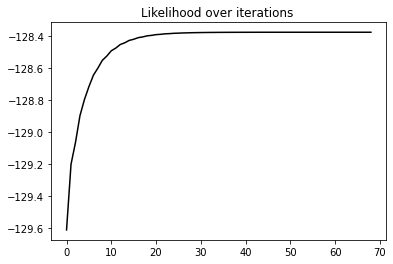

Estimated sigma is  0.96 ; True sigma is  1.0 
Estimated eta is  0.78 ; True eta is  0.8 
Estimated tau is  0.05 ; True tau is  0.05 
Estimated alpha is  0.97 ; True alpha is  1.0


In [6]:
# Use fisher scoring to find MLE parameters
# beta = np.zeros([3, 1])
beta = np.array([[-.9], [1.1], [1.2]])
theta = np.array([[.95], [.75], [.06]])
MAX_ITER = 1000
No_iter = 0
epsilon = 10
Beta = np.zeros([MAX_ITER, 3])
Likelihood = np.zeros([MAX_ITER, 1])

while No_iter < MAX_ITER and epsilon > .0001:

    C = C_matrix(theta)
    # Q = np.linalg.inv(C)
    beta = np.linalg.solve(np.dot(G.T, np.linalg.solve(C, G)), np.dot(G.T, np.linalg.solve(C, y_sampled)))
    Beta[No_iter, ] = beta.T
    z = y_sampled - np.dot(G, beta)
    Likelihood[No_iter, ] = -M/2 * np.log(2 * np.pi) -\
                            1/2 * np.log(np.linalg.det(C)) -\
                            1/2 * np.dot(z.T, np.linalg.solve(C, z))

    # Find dC*/dtheta
    dC_dSgm = dC_dsimga(theta)
    dC_dEta = dC_deta(theta)
    dC_dTau = dC_dtau(theta)

    u_sigma = -1/2 * np.trace(np.linalg.solve(C, dC_dSgm)) + \
              1/2 * np.dot(z.T, np.linalg.solve(C, np.dot(dC_dSgm, np.linalg.solve(C, z))))
    u_eta = -1 / 2 * np.trace(np.linalg.solve(C, dC_dEta)) + \
              1 / 2 * np.dot(z.T, np.linalg.solve(C, np.dot(dC_dEta, np.linalg.solve(C, z))))
    u_tau = -1 / 2 * np.trace(np.linalg.solve(C, dC_dTau)) + \
            1 / 2 * np.dot(z.T, np.linalg.solve(C, np.dot(dC_dTau, np.linalg.solve(C, z))))

    u = np.vstack((u_sigma, u_eta, u_tau))

    V11 = -1/2 * np.trace(np.linalg.solve(C, np.dot(dC_dSgm, np.linalg.solve(C, dC_dSgm))))
    V12 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dSgm, np.linalg.solve(C, dC_dEta))))
    V13 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dSgm, np.linalg.solve(C, dC_dTau))))
    V21 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dEta, np.linalg.solve(C, dC_dSgm))))
    V22 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dEta, np.linalg.solve(C, dC_dEta))))
    V23 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dEta, np.linalg.solve(C, dC_dTau))))
    V31 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dTau, np.linalg.solve(C, dC_dSgm))))
    V32 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dTau, np.linalg.solve(C, dC_dEta))))
    V33 = -1 / 2 * np.trace(np.linalg.solve(C, np.dot(dC_dTau, np.linalg.solve(C, dC_dTau))))

    V = np.array([V11, V12, V13, V21, V22, V23, V31, V32, V33]).reshape(3, 3)

    theta_new = theta - np.linalg.solve(V, u)  # here it is minus, but in the book, it says plus, needs to be rechecked
    epsilon = np.linalg.norm(theta_new - theta, 2) / np.linalg.norm(beta, 2)
    theta = theta_new
    print("epsilon is ", epsilon)
    No_iter += 1
    
# print(beta)
# print(BETA_TRUE)
# print(theta)
# print(THETA_TRUE)

plt.plot(Likelihood[:No_iter], 'k')
plt.title('Likelihood over iterations ')
plt.show()

alphah = (sum(np.abs(beta)) / 3).squeeze()
sigmah = theta[0].squeeze()
etah = theta[1].squeeze()
tauh = theta[2].squeeze()

print("Estimated sigma is ", np.round(sigmah, 2), "; True sigma is ", THETA_TRUE[0].squeeze(), \
      "\nEstimated eta is ", np.round(etah,2), "; True eta is ", THETA_TRUE[1].squeeze(), \
      "\nEstimated tau is ", np.round(tauh,2), "; True tau is ", THETA_TRUE[2].squeeze(), \
      "\nEstimated alpha is ", np.round(alphah, 2), "; True alpha is ", BETA_TRUE[1].squeeze())


The prediction error is  0.548204874429897


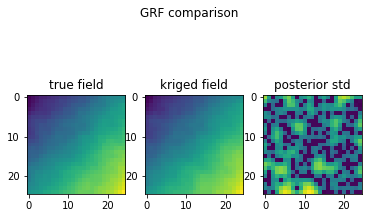

In [7]:
#%% Kriging part
Sigmah = Matern_cov(sigmah, etah, t) # estimated covariance matrix
Lh = np.linalg.cholesky(Sigmah)
mh = mu(H, alphah).reshape(-1, 1) + np.dot(Lh, np.random.randn(n).reshape(-1, 1))
Ch = C_matrix(theta)
xh = mh + np.dot(Sigmah, np.dot(F.T, np.linalg.solve(C, (y_sampled - np.dot(F, mh)))))
# plotf(xh.reshape(n1, n2), "posterior mean")
Sigmap = Sigmah - np.dot(Sigmah, np.dot(F.T, np.linalg.solve(Ch, np.dot(F, Sigmah))))
estd = np.sqrt(np.diag(Sigmap)).reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle('GRF comparison')
ax1.imshow(mu_real.reshape(n1, n2))
ax1.set_title("true field")
ax2.imshow(xh.reshape(n1, n2))
ax2.set_title("kriged field")
ax3.imshow(estd.reshape(n1, n2))
ax3.set_title("posterior std")
MSE = np.sqrt(np.sum(abs(xh - mu_real) ** 2) / n)
print("The prediction error is ", MSE)
